실용 최적화 알고리즘

http://www.yes24.com/Product/Goods/92563359

## automatic gradient
- 실제,예측값 차이의 최소값을 갖도록 gradient descent 최적화 이론

Automatic differentiation in ML

- Numpy 비교해서 ML 프레임워크들은 일반성, 유연성을 포기

- tape-based : 중간에 결과를 저장
    - 복잡한거 저장해서 가져오기, cache 등 장점


In [1]:
import tensorflow as tf

C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [31]:
a = tf.constant([1.,2.,3.])
b = tf.Variable([1.,2.,3.])
b.assign([4,5.,6])

<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([4., 5., 6.], dtype=float32)>

**context manager**

- 안에서 실행된 모든 결과값 tape에 기록

In [20]:
# with를 

with tf.GradientTape() as t:
    # 미분할 함수 넣기
    y = 2 * a 

In [21]:
t.gradient(y)  # dy/dt

TypeError: gradient() missing 1 required positional argument: 'sources'

In [22]:
dy_da = t.gradient(y,a)
dy_da

In [23]:
dy_da = t.gradient(y,a)  # 2번째에 error나옴

# 한 번만 실행가능함.

RuntimeError: GradientTape.gradient can only be called once on non-persistent tapes.

__ enter __ , __ exit __ 한 쌍으로 있어야 with 사용 가능함

In [24]:
with tf.GradientTape() as t:
    y = 2 * b
dy_db = t.gradient(y,b)

In [25]:
dy_db 

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([2., 2., 2.], dtype=float32)>

1. with벗어나면 미분 한 번 밖에 안됨
2. data type은 float32
3. Variable만 가능


- 결과가 빠르게 나와서 좋긴 함.

In [27]:
with tf.GradientTape() as t:
    t.watch(a)
    y = 2 * a 
dy_da = t.gradient(y,a)
dy_da

# watch로 상수도 되게 함

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([2., 2., 2.], dtype=float32)>

In [101]:
with tf.GradientTape(persistent=True, watch_accessed_variables=False) as t:
    t.watch(a)
    y = 2 * a
dy_da = t.gradient(y,a)
dy_da

# persistent=True : 동일한 연산에 대해 2번이상 사용가능
# 다중 호출 허용

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([2., 2., 2.], dtype=float32)>

In [102]:
dy_da = t.gradient(y,a)
dy_da

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([2., 2., 2.], dtype=float32)>

In [103]:
with tf.GradientTape() as t:
    y = 2 * b
    z = y**2
    
dy_db = t.gradient(z,b)
dy_db    

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([32., 40., 48.], dtype=float32)>

In [33]:
with tf.GradientTape() as t:
    y = 2 * b
    z = y**2
    
dz_dy = t.gradient(z,y)
dz_dy  
# 미분해서 2y인데 값으로 튀어나옴

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([16., 20., 24.], dtype=float32)>

In [35]:
y = 2 * b
with tf.GradientTape() as t:
    z = y**2
dz_dy = t.gradient(z,y)
dz_dy
# 안됨

In [36]:
a = 0
with tf.GradientTape() as t:
    if a==0:
        y = 2 * b
        z = y**2
dz_dy = t.gradient(z,y)
dz_dy

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([16., 20., 24.], dtype=float32)>

- numpy는 제공 x
- tensor dataset으로 바꿔야된다.

## gradient tape을 이용한 학습

https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough

- pandas에서 values로 numpy바꾸기
- tensor slice가 numpy지원하기 때문에tf.data.Dataset.from_tensor slice 사용


### dataset

In [50]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
iris = sns.load_dataset('iris')
iris.species = iris.species.map({'setosa' :0, 'versicolor':1,'virginica':2})

In [40]:
tf.data.Dataset.from_tensor_slices(iris.iloc[:,:-1].values)

<TensorSliceDataset shapes: (4,), types: tf.float64>

In [43]:
tf.data.Dataset.from_generator(iter(iris),(tf.float32,tf.float32,tf.float32,tf.float32,tf.int32))
# callable 해야됨.

TypeError: `generator` must be callable.

In [41]:
def x():
    yield 1
    yield 2
    yield 3

In [42]:
x() # callable 해야됨.

<generator object x at 0x00000259D27A1780>

In [44]:
def gen():
    for i in iris.iterrows():
        yield i

In [45]:
x = gen()
next(x)

(0,
 sepal_length       5.1
 sepal_width        3.5
 petal_length       1.4
 petal_width        0.2
 species         setosa
 Name: 0, dtype: object)

In [46]:
tf.data.Dataset.from_generator(gen,(tf.float32,tf.float32,tf.float32,tf.float32,tf.int32))


<FlatMapDataset shapes: (<unknown>, <unknown>, <unknown>, <unknown>, <unknown>), types: (tf.float32, tf.float32, tf.float32, tf.float32, tf.int32)>

### 학습

In [48]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation='relu',input_shape=(4,)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax'),
])

In [49]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam')

In [51]:
model.fit(iris.iloc[:,:-1],iris.species,epochs=5)

Epoch 1/5
5/5 [==============================] - 0s 798us/step - loss: 1.6586
Epoch 2/5
5/5 [==============================] - 0s 599us/step - loss: 1.4639
Epoch 3/5
5/5 [==============================] - 0s 997us/step - loss: 1.2921
Epoch 4/5
5/5 [==============================] - 0s 605us/step - loss: 1.1391
Epoch 5/5
5/5 [==============================] - 0s 798us/step - loss: 1.0411


In [55]:
# 한 번 할때마다 batch size만큼 학습
# fit 보다 내부 구조

model.train_on_batch(iris.iloc[:,:-1],iris.species)

0.9375384449958801

In [56]:
for i in range(10):
    model.train_on_batch(iris.iloc[:,:-1],iris.species)

class weight -> data inbalance

In [66]:
a = tf.Variable([1.,2,3])
with tf.GradientTape() as t:
    y = a**2 + 3*a

In [61]:
# gradient descent의 방법 정하기
optimizer = tf.keras.optimizers.Adam()

In [67]:
dy_da = t.gradient(y,a)
dy_da

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([5., 7., 9.], dtype=float32)>

In [69]:
optimizer.apply_gradients(zip(dy_da,a))
# 첫번째 인자 : gradient를 value에 대해 묶어서 실행
# adam이 gradient계산하는 것

**fit, train_on_batch**
- callbacks
- multi-inputs, outputs 인 복잡한 모델에는 loss function 커스터마이징 하면 적용 불가한 경우가 많음.
- eg. style transfer

**tf.GradientTape**
- 동적 사용
- tensorflow 에만 의존
- 고급기능 이용

In [108]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation='relu',input_shape=(4,)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax'),
])

loss = tf.keras.losses.SparseCategoricalCrossentropy()

complie과 fit을 수동으로

In [105]:
x_train = iris.iloc[:,:-1].values
y_train = iris.species.values

In [80]:
with tf.GradientTape() as t:
    predictions = model(x_train)  # 예측값
    loss_ = loss(y_train,predictions)

In [81]:
model.trainable_variables

[<tf.Variable 'dense_9/kernel:0' shape=(4, 10) dtype=float32, numpy=
 array([[ 0.46443796, -0.5631132 ,  0.41331053,  0.11566538,  0.05689484,
          0.37803042, -0.36628526, -0.5381659 ,  0.1265077 , -0.10558778],
        [ 0.209791  , -0.06761456, -0.15256882,  0.53608954, -0.3813281 ,
          0.11972892,  0.50992095, -0.6503102 ,  0.35385573,  0.13981211],
        [ 0.5520718 , -0.11684656,  0.298981  , -0.07453817,  0.35184753,
         -0.38037756,  0.2953273 ,  0.46252584,  0.11583   ,  0.28884226],
        [-0.15207654, -0.37631336,  0.2205494 ,  0.35054493, -0.5720679 ,
          0.6113715 , -0.56134593,  0.32933652, -0.49595535,  0.5236027 ]],
       dtype=float32)>,
 <tf.Variable 'dense_9/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense_10/kernel:0' shape=(10, 10) dtype=float32, numpy=
 array([[ 0.10578495, -0.1318205 ,  0.2185666 , -0.43139324,  0.17732114,
          0.44062132, -0.5107225 , -

In [83]:
model.trainable_weights is model.trainable_variables

False

In [85]:
model.trainable_weights == model.trainable_variables

# 값은 같지만 다른 객체를 통해 만들어짐
# variable이 학습할 때 쓰고 weights는 보여줄 때 주로 씀

True

In [86]:
grad = t.gradient(loss_,model.trainable_variables)

In [88]:
optimizer = tf.keras.optimizers.Adam()
optimizer.apply_gradients(zip(grad,model.trainable_variables))
# 한번의 학습이 이루어진 것..

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [89]:
train_loss = tf.keras.metrics.Mean()
train_acc = tf.keras.metrics.SparseCategoricalAccuracy()

In [106]:
@tf.function

def train(x_train, y_train):
    with tf.GradientTape() as t:
        predictions = model(x_train)  # 예측값
        loss_ = loss(y_train,predictions)
        
    grad = t.gradient(loss_,model.trainable_variables)
    optimizer.apply_gradients(zip(grad,model.trainable_variables))
    train_loss(loss_)
    train_acc(y_train,predictions)

tf.function : numpy로 되어있어도 tensor 바꿔서 함

In [98]:
for i in range(30):
    train(x_train,y_train)

In [92]:
# dir(train_acc)  -> result

In [99]:
train_acc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.33333334>

In [110]:
train_loss_results = []
train_accuracy_results = []

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function

def train(x_train, y_train):
    with tf.GradientTape() as t:
        predictions = model(x_train)  # 예측값
        loss_ = loss(y_train,predictions)
        
    grad = t.gradient(loss_,model.trainable_variables)
    optimizer.apply_gradients(zip(grad,model.trainable_variables))
    train_loss(loss_)
    train_acc(y_train,predictions)
    
for i in range(20):
    train(x_train,y_train)
    train_loss_results.append(train_loss.result())
    train_accuracy_results.append(train_acc.result())
    print(i , train_acc.result()) # tf내부 문제로  밖에서 출력해야

0 tf.Tensor(0.3200823, shape=(), dtype=float32)
1 tf.Tensor(0.32430893, shape=(), dtype=float32)
2 tf.Tensor(0.32843372, shape=(), dtype=float32)
3 tf.Tensor(0.3324603, shape=(), dtype=float32)
4 tf.Tensor(0.33639216, shape=(), dtype=float32)
5 tf.Tensor(0.34023255, shape=(), dtype=float32)
6 tf.Tensor(0.34398466, shape=(), dtype=float32)
7 tf.Tensor(0.3476515, shape=(), dtype=float32)
8 tf.Tensor(0.35123596, shape=(), dtype=float32)
9 tf.Tensor(0.35474074, shape=(), dtype=float32)
10 tf.Tensor(0.3581685, shape=(), dtype=float32)
11 tf.Tensor(0.3615942, shape=(), dtype=float32)
12 tf.Tensor(0.3651613, shape=(), dtype=float32)
13 tf.Tensor(0.36893618, shape=(), dtype=float32)
14 tf.Tensor(0.37277192, shape=(), dtype=float32)
15 tf.Tensor(0.37659723, shape=(), dtype=float32)
16 tf.Tensor(0.38061854, shape=(), dtype=float32)
17 tf.Tensor(0.38517007, shape=(), dtype=float32)
18 tf.Tensor(0.389899, shape=(), dtype=float32)
19 tf.Tensor(0.3952, shape=(), dtype=float32)


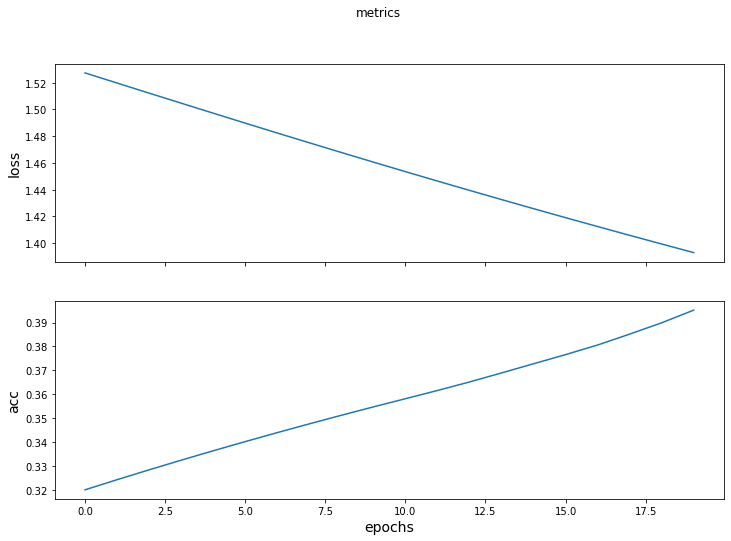

In [112]:
import numpy as np
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('metrics')

axes[0].set_ylabel("loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("acc", fontsize=14)
axes[1].set_xlabel("epochs", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

In [113]:

predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
    class_idx = tf.argmax(logits).numpy()
    p = tf.nn.softmax(logits)[class_idx]
    name = [ 'setosa','versicolor','virginica'][class_idx]
    print("샘플 {} 예측: {} ({:4.1f}%)".format(i, name, 100*p))

샘플 0 예측: setosa (56.5%)
샘플 1 예측: versicolor (39.9%)
샘플 2 예측: virginica (46.7%)
